# **Load libraries**

In [1]:
!pip install datashader bokeh holoviews scikit-image colorcet umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.9 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=964242582d5c6b29357864cd8d7ca76576b23ebec703524de7ed4e628dce92bf
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from umap import UMAP
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import torch
from sklearn.manifold import TSNE
import umap.plot
from sklearn.preprocessing  import MinMaxScaler
from collections import Counter

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).

    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1:    The mean of the activations of preultimate layer of the
               CHEMNET (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2:    The mean of the activations of preultimate layer of the
               CHEMNET (like returned by the function 'get_predictions')
               for real samples.
    -- sigma1: The covariance matrix of the activations of preultimate layer
               of the CHEMNET (like returned by the function 'get_predictions')
               for generated samples.
    -- sigma2: The covariance matrix of the activations of preultimate layer
               of the CHEMNET (like returned by the function 'get_predictions')
               for real samples.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            #raise ValueError("Imaginary component {}".format(m))
            print("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

In [4]:
def get_w2(act1, act2):

    """Calculate w2 between two sets

    Args:
        act1: First set
        act2: Second set

    Returns:
        float: The FCD score
    """

    mu1 = np.mean(act1, axis=0)
    sigma1 = np.cov(act1.T)

    mu2 = np.mean(act2, axis=0)
    sigma2 = np.cov(act2.T)

    fcd_score = calculate_frechet_distance(
        mu1=mu1, mu2=mu2, sigma1=sigma1, sigma2=sigma2
    )

    return fcd_score

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# **Prepare the esm2 input**

In [ ]:
upper_limit = 30
lower_limit = 5

wang_fasta = pd.read_csv(f'drive/MyDrive/Oslo/data/paper/FASTA/combined_cdr3_heavy.csv', sep=';')
wang_fasta = wang_fasta.rename(columns={'seq': 'junction_aa'})
wang_fasta['junction_length'] = wang_fasta['junction_aa'].apply(len)
wang_fasta = wang_fasta[(wang_fasta['junction_length'] <= upper_limit) & (wang_fasta['junction_length'] >= lower_limit)]

wang_fasta = wang_fasta.iloc[:800000]

wang_fasta['id'] = range(1, len(wang_fasta) + 1)

wang_fasta

,index,junction_aa,junction_length,id
0,1,ASGAVTDFVY,10,1
1,2,AKEGPLYSSGYYFDY,15,2
2,3,TTDRTHYYDSFY,12,3
3,4,SHQIDYHYRMDF,12,4
4,5,ARDPGPSYDLLTGGGGTFDL,20,5
...,...,...,...,...
794615,794616,VKDLYSGRFYYFLDD,15,793889
794616,794617,GRVGSRATGLPDWIDP,16,793890
794617,794618,ARQGLTSSWYDGSGLDV,17,793891
794618,794619,VLLTVLTPDDAFDI,14,793892


In [ ]:
upper_limit = 30
lower_limit = 5

def crop_sequence(seq):
    # Check if the sequence has a length greater than 2 to avoid errors
    if len(seq) > 2:
        return seq[1:-1]  # Crop the first and last letter
    else:
        return seq  # Return the sequence unchanged if it's too short

ireceptor_fasta = pd.read_csv(f'drive/MyDrive/Oslo/data/ireceptor/H_CDR3.csv', sep=';')
ireceptor_fasta = ireceptor_fasta.rename(columns={'seq': 'junction_aa'})
ireceptor_fasta['junction_aa'] = ireceptor_fasta['junction_aa'].apply(crop_sequence)
ireceptor_fasta['junction_length'] = ireceptor_fasta['junction_aa'].apply(len)
ireceptor_fasta = ireceptor_fasta[(ireceptor_fasta['junction_length'] <= upper_limit) & (ireceptor_fasta['junction_length'] >= lower_limit)]

ireceptor_fasta = ireceptor_fasta.iloc[:800000]

ireceptor_fasta['id'] = range(1, len(ireceptor_fasta) + 1)

ireceptor_fasta

,sequence_id,sequence_aa,productive,locus,v_call,d_call,j_call,c_call,junction_aa,duplicate_count,repertoire_id,cdr1_aa,cdr2_aa,cdr3_aa,id,junction_length
0,5f39ba19616aa7007f0781cb,NaN,True,IGH,IGHV3-23*01,IGHD3-16*01,IGHJ4*02,IgM,AKCGDGIYADYYFDY,NaN,4941241542787076586-242ac113-0001-012,GFTFSSYA,ISGSGGST,AKCGDGIYADYYFDY,1,15
1,5f39dbfa616aa7007f274a4b,NaN,True,IGH,IGHV3-30*18,IGHD4-17*01,IGHJ4*02,IgM,AKGGGTVTTGGFDY,NaN,4250138355187716586-242ac113-0001-012,GFTFSSYW,ISYDGSNK,AKGGGTVTTGGFDY,2,14
2,5f3b63aa616aa7007f97e5a3,NaN,True,IGH,IGHV3-23*01,IGHD3-22*01,IGHJ5*02,IgM,AKDSSAWSKDS,NaN,401804708298756586-242ac113-0001-012,GFSFSNYA,ITDNGDYT,AKDSSAWSKDS,3,11
3,5f3bf67b616aa7007f99fe44,NaN,True,IGH,IGHV4-59*10,IGHD3-22*01,IGHJ4*02,IgM,ARETYYYDSSGYYINYFDY,NaN,1025069326778428950-242ac113-0001-012,GGSFSGYY,IYPSGST,ARETYYYDSSGYYINYFDY,4,19
4,5f3ab978616aa7007fbccf00,NaN,True,IGH,IGHV4-31*03,IGHD3-10*01,IGHJ4*02,IgM,AREGVNRTWFGELSPPYFDY,NaN,2690893428047876586-242ac113-0001-012,GGSISSGGYY,IYYSGST,AREGVNRTWFGELSPPYFDY,5,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,5f3c3df3616aa7007f1b2e71,NaN,True,IGH,IGHV1-8*02,IGHD3-22*01,IGHJ4*02,IgM,ARGTIAVANDY,NaN,1279975635796028950-242ac113-0001-012,GYTFTNYD,MNPYSANT,ARGTIAVANDY,799505,11
799996,5f3b4eda616aa7007fd050ab,NaN,True,IGH,IGHV3-30*04,IGHD3-16*01,IGHJ3*02,IgG1,ARVPDFGELQLFAYDI,NaN,667104838172676586-242ac113-0001-012,GFTFSSYA,ISYDGSNK,ARVPDFGELQLFAYDI,799506,16
799997,5f3c116d616aa7007f9098f9,NaN,True,IGH,IGHV4-59*01,IGHD3-10*02,IGHJ4*02,IgM,ARASVLLSADF,NaN,1137382721568828950-242ac113-0001-012,GGYIGSFY,IYSSGST,ARASVLLSADF,799507,11
799998,5f3bca2d616aa7007f1b738f,NaN,True,IGH,IGHV1-2*03,IGHD2-8*02,IGHJ4*02,IgM,ARVRVVNSKAFDY,NaN,891281095508028950-242ac113-0001-012,GYTFTSYA,INPHSGGT,ARVRVVNSKAFDY,799508,13


In [ ]:
common = pd.merge(ireceptor_fasta, wang_fasta, on=['junction_aa'])

print(f"The number of common records is: {len(common)}")

The number of common records is: 4219


In [ ]:
mask = ~ireceptor_fasta['junction_aa'].isin(wang_fasta['junction_aa'])

# Apply the mask to df1 to filter out the common records
ireceptor_fasta = ireceptor_fasta[mask]
ireceptor_fasta['id'] = range(1, len(ireceptor_fasta) + 1)

common = pd.merge(ireceptor_fasta, wang_fasta, on=['junction_aa'])

print(f"The number of common records is: {len(common)}")

<ipython-input-7-301a4f80bfcb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ireceptor_fasta['id'] = range(1, len(ireceptor_fasta) + 1)


The number of common records is: 0


<ipython-input-8-bb9e90657c4f>:16: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=df_melted, x='DataFrame', y='Junction Length', linewidth=0.5, scale="width")


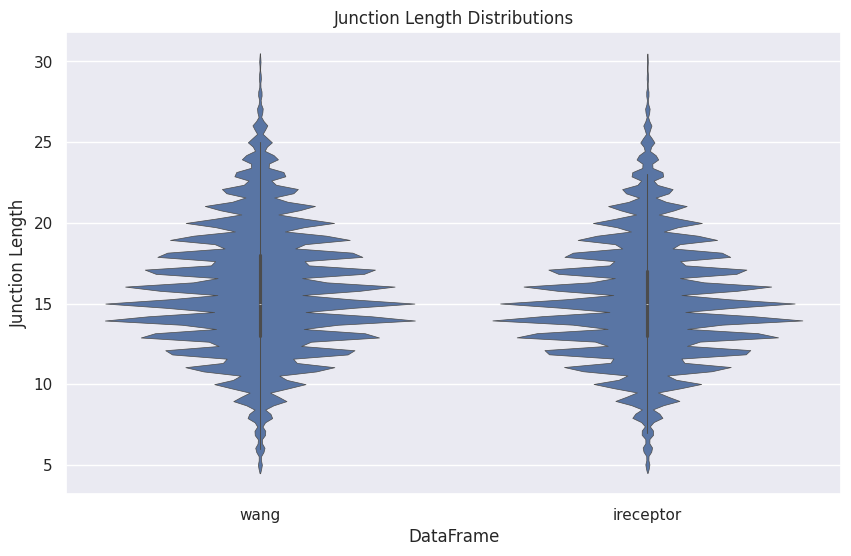

In [ ]:
# Extract the 'junction_length' column from each DataFrame
length_wang = wang_fasta['junction_length']
length_ireceptor = ireceptor_fasta['junction_length']

# Combine the data and labels into one DataFrame for seaborn
df = pd.DataFrame({
    'wang': length_wang,
    'ireceptor': length_ireceptor
})

# Melt the DataFrame to long-format required by seaborn
df_melted = df.melt(var_name='DataFrame', value_name='Junction Length')

# Create a violinplot to compare the distributions
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_melted, x='DataFrame', y='Junction Length', linewidth=0.5, scale="width")
plt.title('Junction Length Distributions')
plt.xlabel('DataFrame')
plt.ylabel('Junction Length')
plt.show()

In [ ]:
print(len(wang_fasta))
print(len(ireceptor_fasta))

793893
795290


In [ ]:
data_size = 700000

wang_fasta = wang_fasta.iloc[:data_size]
ireceptor_fasta = ireceptor_fasta.iloc[:data_size]

In [ ]:
wang_fasta.to_csv(f'/content/drive/MyDrive/Oslo/data/overlap_test/wang.csv', index=False, sep=';')

with open(f'/content/drive/MyDrive/Oslo/data/overlap_test/wang.fa', 'w') as file:
    for index, row in wang_fasta.iterrows():
        id = row['id']
        cdr_aa = row['junction_aa']

        # Write the FASTA entry
        file.write(f'>{id}\n{cdr_aa}\n')

In [ ]:
ireceptor_fasta.to_csv(f'/content/drive/MyDrive/Oslo/data/overlap_test/ireceptor.csv', index=False, sep=';')

with open(f'/content/drive/MyDrive/Oslo/data/overlap_test/ireceptor.fa', 'w') as file:
    for index, row in ireceptor_fasta.iterrows():
        id = row['id']
        cdr_aa = row['junction_aa']

        # Write the FASTA entry
        file.write(f'>{id}\n{cdr_aa}\n')

# **Create overlapping tensors**

In [18]:
wang = torch.load(f'drive/MyDrive/Oslo/data/freq_test/output/esm2/wang_790000.pt').numpy()

print(len(wang))

790000


In [19]:
ireceptor = torch.load(f'drive/MyDrive/Oslo/data/freq_test/output/esm2/ireceptor_790000.pt').numpy()

print(len(ireceptor))

790000


In [8]:
num_vectors = len(ireceptor)
replacement_rate = 0.10   # 10%
num_vectors_to_replace = int(num_vectors * replacement_rate)

# Initialize an array to store the distances
w2_array = []

# Replace 10% of the vectors at each step and compute distance
for step in range(0, 11):  # 10 steps incrementally replacing: 10%, 20%, ..., 100%
    # Calculate the ending index for replacement
    end_idx = num_vectors_to_replace * step

    # Replace the vectors in ireceptor with those from wang
    ireceptor[:end_idx] = wang[:end_idx]

    # Measure the distance and store it
    distance = get_w2(wang, ireceptor)
    w2_array.append(distance)

    # Optionally print out the replacement progress and the distance at each step
    print(f"Step {step}: Replaced {step*10}% of ireceptor. Distance: {distance}")

Step 0: Replaced 0% of ireceptor. Distance: 0.014502981820372796
Step 0: Replaced 0% of ireceptor. Distance: 0.014502981820372796
Step 1: Replaced 10% of ireceptor. Distance: 0.01193174650436113
Step 2: Replaced 20% of ireceptor. Distance: 0.009650889306101362
Step 3: Replaced 30% of ireceptor. Distance: 0.007439955429016543
Step 4: Replaced 40% of ireceptor. Distance: 0.005479925519193962
Step 5: Replaced 50% of ireceptor. Distance: 0.004236141148263428
Step 6: Replaced 60% of ireceptor. Distance: 0.003170632401210405
Step 7: Replaced 70% of ireceptor. Distance: 0.0027219490955152637
Step 8: Replaced 80% of ireceptor. Distance: 0.0012376251402335114
Step 9: Replaced 90% of ireceptor. Distance: 0.00027632055438608916
Step 10: Replaced 100% of ireceptor. Distance: 1.1368683772161603e-13


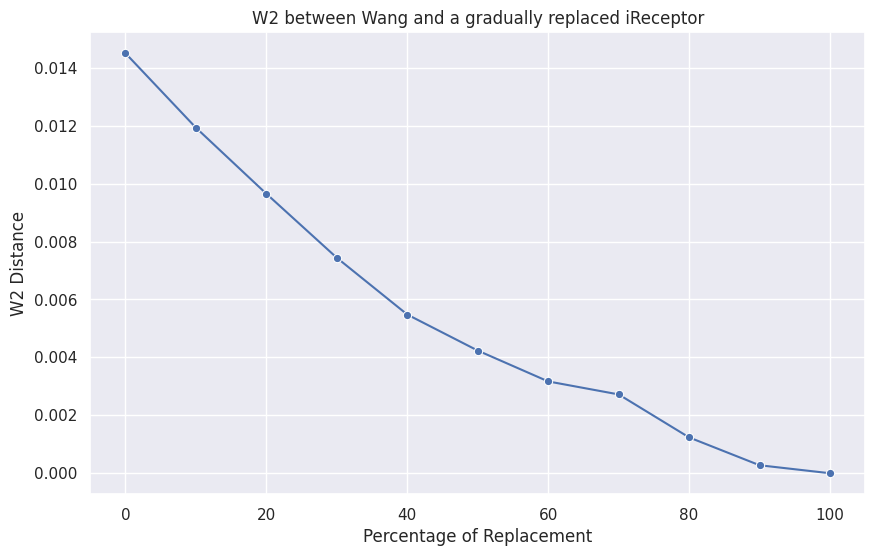

In [15]:
sns.set_theme()
plt.figure(figsize=(10, 6))

# Generate the percentages of replacement corresponding to each step
replacement_percentages = [10 * i for i in range(0, 11)]

# Create a plot using Seaborn
sns.lineplot(x=replacement_percentages, y=w2_array, marker="o")

# Set the axis labels
plt.xlabel('Percentage of Replacement')
plt.ylabel('W2 Distance')
plt.title('W2 between Wang and a gradually replaced iReceptor')

plt.savefig('w2_overlap.png')

# Show the plot
plt.show()

In [20]:
from random import sample

num_vectors = len(ireceptor)
replacement_rate = 0.10   # 10%
num_vectors_to_replace = int(num_vectors * replacement_rate)

# Initialize an array to store the distances
w2_array = []

# Keep track of the indices that have already been replaced
replaced_indices = set()

# Replace 10% of the vectors at each step and compute distance
for step in range(1, 11): # 10 steps of random 10% replacement (cumulative)
    # Generate the remaining available indices
    remaining_indices = list(set(range(num_vectors)) - replaced_indices)

    # Randomly select new indices to replace, ensuring no duplication
    new_indices = sample(remaining_indices, num_vectors_to_replace)
    replaced_indices.update(new_indices)

    # Replace the vectors in ireceptor with those from wang at the selected indices
    new_indices_tensor = torch.tensor(new_indices)
    ireceptor[new_indices_tensor] = wang[new_indices_tensor]

    # Measure the distance and store it
    distance = get_w2(wang, ireceptor)
    w2_array.append(distance)

    # Optionally print out the replacement progress and the distance at each step
    print(f"Step {step}: Replaced a unique random 10% of ireceptor. Distance: {distance}")

Step 0: Replaced a unique random 10% of ireceptor. Distance: 0.011805181449387803
Step 1: Replaced a unique random 10% of ireceptor. Distance: 0.00935712618306983
Step 2: Replaced a unique random 10% of ireceptor. Distance: 0.007126370097017443
Step 3: Replaced a unique random 10% of ireceptor. Distance: 0.005265217277146128
Step 4: Replaced a unique random 10% of ireceptor. Distance: 0.0036803908761520177
Step 5: Replaced a unique random 10% of ireceptor. Distance: 0.0023658009613711783
Step 6: Replaced a unique random 10% of ireceptor. Distance: 0.001332588090791731
Step 7: Replaced a unique random 10% of ireceptor. Distance: 0.0006092798668131394
Step 8: Replaced a unique random 10% of ireceptor. Distance: 0.00016916744084038982
Step 9: Replaced a unique random 10% of ireceptor. Distance: 1.1368683772161603e-13


ValueError: Sample larger than population or is negative

In [23]:
w2_array.insert(0, 0.014502981820372796)
w2_array

[0.014502981820372796,
 0.011805181449387803,
 0.00935712618306983,
 0.007126370097017443,
 0.005265217277146128,
 0.0036803908761520177,
 0.0023658009613711783,
 0.001332588090791731,
 0.0006092798668131394,
 0.00016916744084038982,
 1.1368683772161603e-13]

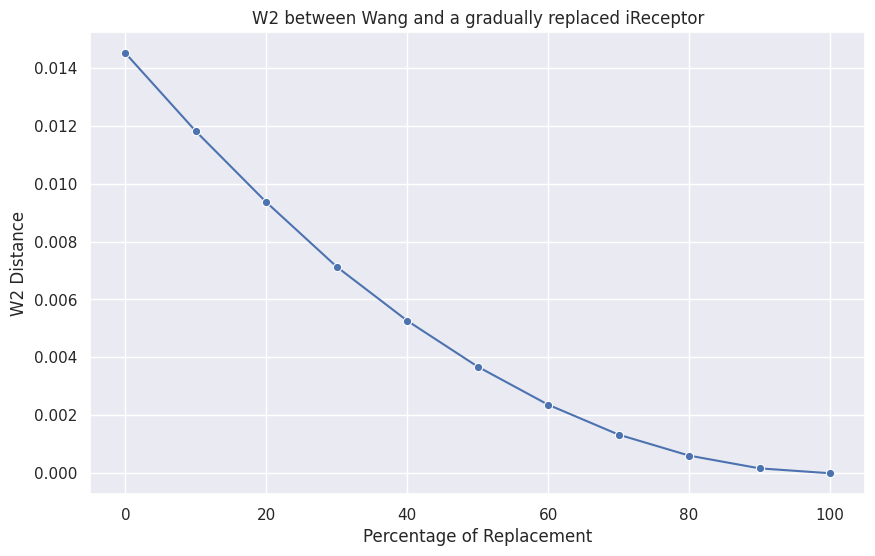

In [24]:
sns.set_theme()
plt.figure(figsize=(10, 6))

# Generate the percentages of replacement corresponding to each step
replacement_percentages = [10 * i for i in range(0, 11)]

# Create a plot using Seaborn
sns.lineplot(x=replacement_percentages, y=w2_array, marker="o")

# Set the axis labels
plt.xlabel('Percentage of Replacement')
plt.ylabel('W2 Distance')
plt.title('W2 between Wang and a gradually replaced iReceptor')

plt.savefig('w2_overlap_2.png')

# Show the plot
plt.show()

In [29]:
wang = torch.load(f'drive/MyDrive/Oslo/data/freq_test/output/esm2/wang_790000.pt').numpy()

ireceptor = torch.load(f'drive/MyDrive/Oslo/data/freq_test/output/esm2/ireceptor_790000.pt').numpy()

middle = np.copy(ireceptor)
rand_indices = torch.randperm(len(ireceptor))[:int(len(ireceptor) * 0.3)]
middle[rand_indices] = wang[rand_indices]

#end_idx = int(len(ireceptor) * 0.5)
#middle[:end_idx] = wang[:end_idx]

In [30]:
print(f'W2 between wang and middle: {get_w2(wang, middle)}')
print(f'W2 between middle and ireceptor: {get_w2(middle, ireceptor)}')
print(f'W2 between wang and ireceptor: {get_w2(wang, ireceptor)}')

W2 between wang and middle: 0.007067665840012616
W2 between middle and ireceptor: 0.001411864271389618
W2 between wang and ireceptor: 0.014502981820372796
